In [41]:
import numpy as np
import pandas as pd
import gudhi as gd
import sys
import matplotlib.pyplot as plt
import networkx as nx
from ripser import Rips
import pickle
import os
import persim
from sklearn.manifold import TSNE
from matplotlib.pyplot import figure

In [42]:
# for s_n in G:
#     try:
#         forward = np.load(f"dgms/pd_{s_n}.npy")
#         backward = np.load(f"dgms_back/pd_{s_n}.npy")
#         dgms = forward + backward
#         np.save(f"dgms/pd_{s_n}.npy", dgms)
#     except:
#         continue

In [43]:
class Graph:
    # Constructor
    def __init__(self, edges, n):
 
        # A list of lists to represent an adjacency list
        self.adjList = [[] for _ in range(n)]
 
        # add edges to the directed graph
        for (source, dest, weight) in edges:
            self.adjList[source].append((dest, weight))
 
 
# Perform DFS on the graph and set the departure time of all
# vertices of the graph
def DFS(graph, v, discovered, departure, time):
    # mark the current node as discovered
    discovered[v] = True
 
    # set arrival time – not needed
    # time = time + 1
 
    # do for every edge (v, u)
    for (u, w) in graph.adjList[v]:
        # if `u` is not yet discovered
        if not discovered[u]:
            time = DFS(graph, u, discovered, departure, time)
 
    # ready to backtrack
    # set departure time of vertex `v`
    departure[time] = v
    time = time + 1
 
    return time
 
def findLongestDistance(graph, source, n):
    # `departure` stores vertex number having its departure
    # time equal to the index of it
    departure = [-1] * n
 
    # to keep track of whether a vertex is discovered or not
    discovered = [False] * n
    time = 0
 
    # perform DFS on all undiscovered vertices
    for i in range(n):
        if not discovered[i]:
            time = DFS(graph, i, discovered, departure, time)
 
    cost = [sys.maxsize] * n
    cost[source] = 0
 
    # Process the vertices in topological order, i.e., in order
    # of their decreasing departure time in DFS
    added = []
    
    for i in reversed(range(n)):
     
        # for each vertex in topological order,
        # relax the cost of its adjacent vertices
        v = departure[i]
        # edge from `v` to `u` having weight `w`
        for (u, w) in graph.adjList[v]:
            w = -w     # make edge weight negative
            # if the distance to destination `u` can be shortened by
            # taking edge (v, u), then update cost to the new lower value
            if cost[v] != sys.maxsize and cost[v] + w < cost[u]:
                cost[u] = cost[v] + w
                
            
    
    
    dist = dict()
    for i in range(n):
        dist[i] = {-cost[i]}
        
    return dist

In [44]:
netlist_name = 'jpeg_300_off_low_GENUS'

with open('d_dict.pkl', 'rb') as f:
    new_d_dict = pickle.load(f)

with open('delay_dict.pkl', 'rb') as f:
    delay_dict = pickle.load(f)
    
s_inst = np.load("s_inst.npy", allow_pickle=True)

G = nx.read_gpickle(f"{netlist_name}.gpickle")

Vn = G.number_of_nodes()

#sn_lst = np.random.choice(nodelist, size=10, replace=False)
sn_lst = [32524, 52754, 16900, 23764, 38509, 39949, 67723, 24287, 12000, 51153]

In [43]:
#sn_lst = p_input
all_data = []
for sn in sn_lst:
    pre_sub_Vn = 9
    sub_Vn = 0
    r = 1
    r_lst = []
    Vn_lst = []
    while sub_Vn < Vn - 1: 
        sub_g = nx.ego_graph(G, sn, radius=r)
        sub_Vn = sub_g.number_of_nodes()
        if sub_Vn == pre_sub_Vn:
            break
        r_lst.append(r)
        Vn_lst.append(sub_Vn)
        r += 1
        pre_sub_Vn = sub_Vn
        
    all_data.append((r_lst, Vn_lst))

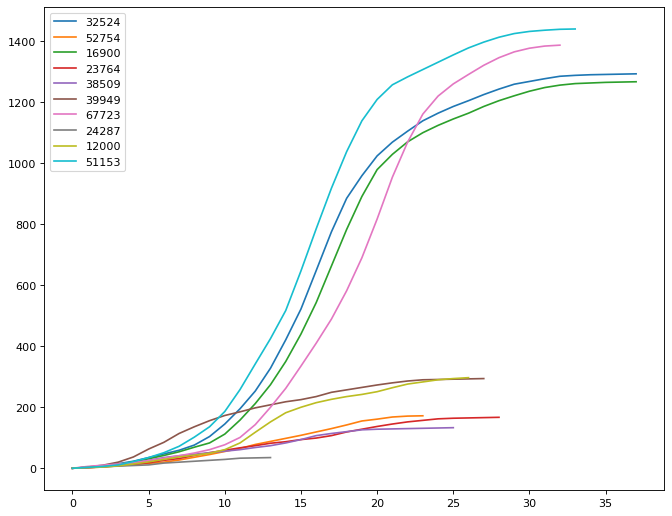

In [44]:
figure(figsize=(10, 8), dpi=80)
for tp in all_data:
    r_lst = [0] + tp[0]
    Vn_lst = [0] + tp[1]
    
    plt.plot(r_lst, Vn_lst)
    plt.legend(sn_lst)

plt.show()

In [22]:
all_data = []
for sn in sn_lst:
    all_dist_raw = []
    p_input = [sn]
    for node in p_input: 
        gen = nx.edge_dfs(G, source=node)
        delay_dict = {}
        delay_dict[node] = 0

        for edge in list(gen):
            n1 = edge[0]
            n2 = edge[1]
            delay = delay_dict[n1] + 1
            if n2 in delay_dict.keys():
                if delay > delay_dict[n2]:
                    delay_dict[n2] = delay

            else:
                delay_dict[n2] = delay

        all_dist_raw.append(delay_dict)

    all_dist = {}
    for delay_dict in all_dist_raw:
        for key in delay_dict.keys():
            if key in all_dist.keys():
                if delay_dict[key] > all_dist[key]:
                    all_dist[key] = delay_dict[key]
            else:
                all_dist[key] = delay_dict[key]

    delay_dict = all_dist
    
    d_lst = []
    for delay in range(max(delay_dict.values()) + 1):
        delay_level_lst = []
        for node in delay_dict.keys():
            if delay_dict[node] == delay:
                delay_level_lst.append(node)

        if len(delay_level_lst) == 0:
            continue
        d_lst.append(delay_level_lst)
        
    print(sn, len(d_lst))
    
    r_lst = [len(lst) for lst in d_lst]
    l_lst = [idx for idx in range(len(d_lst))]
    
    all_data.append((r_lst, l_lst))

32524 68
52754 37
16900 82
23764 42
38509 36
39949 37
67723 94
24287 14
12000 39
51153 69


In [ ]:
32524 177
52754 36
16900 203
23764 35
38509 36
39949 39
67723 200
24287 14
12000 50
51153 188

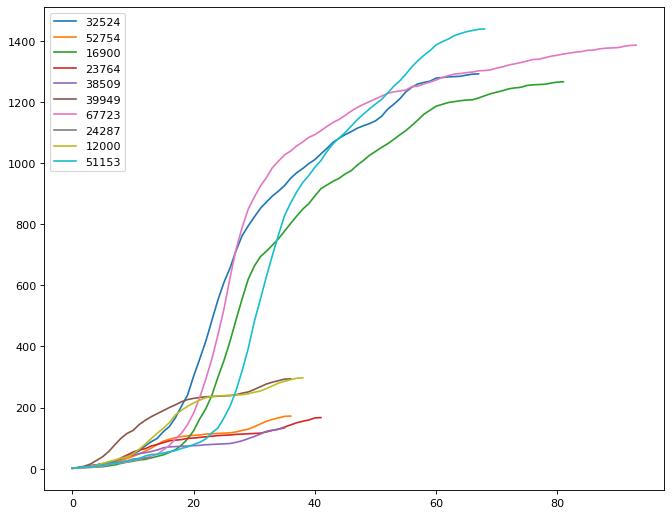

In [23]:
figure(figsize=(10, 8), dpi=80)
for tp in all_data:
    r_lst = tp[1]
    Vn_lst = tp[0]
    
    cum_Vn = 0
    final_Vn = []
    for Vn in Vn_lst:
        cum_Vn += Vn
        final_Vn.append(cum_Vn)
    
    plt.plot(r_lst, final_Vn)
    plt.legend(sn_lst)

plt.show()

In [45]:
sub_G = nx.ego_graph(G, 35, radius=50).reverse()
nodelist = np.load("nodelist.npy")

In [46]:
i = 0
n_nodelist = []
for s_n in sub_G:
    sub_g = nx.ego_graph(sub_G, s_n, radius=10)
    edgs = list(sub_g.edges)
    if len(edgs) <= 4:
        continue
    n_nodelist.append(s_n)
    col = []
    row = []
    for edg in edgs:
        col.append(edg[0])
        row.append(edg[1])

    p_input = set()
    p_output = set()
    
    p_input.add(s_n)
    
    o_d = sub_g.out_degree
    i_d = sub_g.in_degree

    for node in sub_g:
        if o_d[node] == 0 and i_d[node] == 0:
            continue

        if o_d[node] == 0:
            p_output.add(node)

        if i_d[node] == 0:
            p_input.add(node)
    
    #####################################
    nn = sub_g.number_of_nodes()
    idx_dict = {list(sub_g.nodes)[idx]:idx for idx in range(nn)}
    all_dist_raw = []
    edgs_d = [(idx_dict[lst[0]], idx_dict[lst[1]], 1) for lst in edgs] 
    graph = Graph(edgs_d, nn)
    
    if len(p_input) == 1:
        delay_dict = findLongestDistance(graph, idx_dict[s_n], nn)
        delay_dict = {key: delay_dict[key].pop() for key in delay_dict.keys()}
        
    else:
        for node in p_input: all_dist_raw.append(findLongestDistance(graph, idx_dict[node], nn))

        # building the delay based dictionary
        delay_dict = all_dist_raw[0]
        delay_dict = {key: list(delay_dict[key]) for key in delay_dict.keys()}
        for dist in all_dist_raw[1:]:
            for key in dist.keys(): 
                val = dist[key]
                if key in delay_dict.keys():
                    delay_dict[key] = delay_dict[key] + list(val)
                else:
                    delay_dict[key] = list(val)

        delay_dict = {key: max(delay_dict[key]) for key in delay_dict.keys()}
    ##########################################
    
    d_lst = []
    for delay in range(max(delay_dict.values()) + 1):
        delay_level_lst = []
        for node in delay_dict.keys():
            if delay_dict[node] == delay:
                delay_level_lst.append(node)

        if len(delay_level_lst) == 0:
            continue
        d_lst.append(delay_level_lst)
    to_level = len(d_lst) 
    st = gd.SimplexTree()

    edgs = [(idx_dict[edg[0]], idx_dict[edg[1]]) for edg in edgs]
    for edg in edgs:
        st.insert(edg)


    for delay in range(to_level):
        nodes = d_lst[delay]
        for node in nodes:
            st.assign_filtration([node], delay)
            
    st.extend_filtration()
    dgms = st.extended_persistence()
    np.save(f"dgms/pd_back_{s_n}.npy", dgms)
    i += 1

    if i//1000 > 0 and i%1000 == 0:
        print(i)

1000
2000


In [49]:
np.save("nodelist_back.npy", n_nodelist)